In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import defaultdict

# Load the dataset
df = pd.read_csv('Student-Employability-Datasets.csv')  # Replace with your actual CSV file name
# Firstly delete not needed column
df.drop(columns="Name of Student", inplace=True)

In [61]:
# Function to find and remove rows with identical feature values but different outcomes
def remove_inconsistent_rows(df, outcome_column):
    # Identify feature columns (all columns except the outcome column)
    feature_columns = df.columns.drop(outcome_column).tolist()
    # TEMPORARY CHANGE BC I REMOVE IDENTICALS ONLY IN X_TRAIN
    # feature_columns = df.columns.tolist()
    # Group by all feature columns
    grouped = df.groupby(feature_columns)
    
    # Identify groups where the outcome is not unique
    inconsistent_groups = grouped.filter(lambda x: x[outcome_column].nunique() > 1)
    
    # Get the indices of the inconsistent rows
    inconsistent_indices = inconsistent_groups.index
    
    # Remove the inconsistent rows from the original dataframe
    df_cleaned = df.drop(inconsistent_indices)
    
    return df_cleaned, inconsistent_groups


In [48]:
# Remove inconsistent rows and get the inconsistent rows
df_cleaned, inconsistent_rows = remove_inconsistent_rows(df, 'CLASS')
df_cleaned.shape

(2246, 9)

In [ ]:
# Separate features and target
X = df.drop('CLASS', axis=1)  # Replace 'employability' with your actual target column name
y = df['CLASS']  # Replace 'employability' with your actual target column name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Concatenate X_train and y_train
merged_df = pd.concat([X_train, y_train], axis=1)
train_df_cleaned, inconsistent_rows = remove_inconsistent_rows(merged_df, 'CLASS')

X_train_cleaned_identicals = train_df_cleaned.drop('CLASS', axis=1)
y_train_cleaned_identicals = train_df_cleaned['CLASS']
y_train_cleaned_identicals


In [63]:
merged_df.shape

(1789, 9)

['Employable' 'Employable' 'Employable' ... 'Employable' 'Employable'
 'Employable']
Accuracy: 0.7930

Classification Report:
                precision    recall  f1-score   support

    Employable       0.74      0.95      0.84       658
LessEmployable       0.91      0.60      0.72       535

      accuracy                           0.79      1193
     macro avg       0.83      0.77      0.78      1193
  weighted avg       0.82      0.79      0.78      1193


Confusion Matrix:
[[626  32]
 [215 320]]

Cross-validation scores: [0.86764706 0.88235294 0.95955882 0.87132353 0.96323529]
Mean CV score: 0.9088 (+/- 0.0432)

Feature Importance:
                      feature  importance
7  Student Performance Rating    0.186406
3            MENTAL ALERTNESS    0.180285
1          MANNER OF SPEAKING    0.173338
4             SELF-CONFIDENCE    0.167091
5    ABILITY TO PRESENT IDEAS    0.089779
6        COMMUNICATION SKILLS    0.086575
0          GENERAL APPEARANCE    0.058607
2          PHYSICA

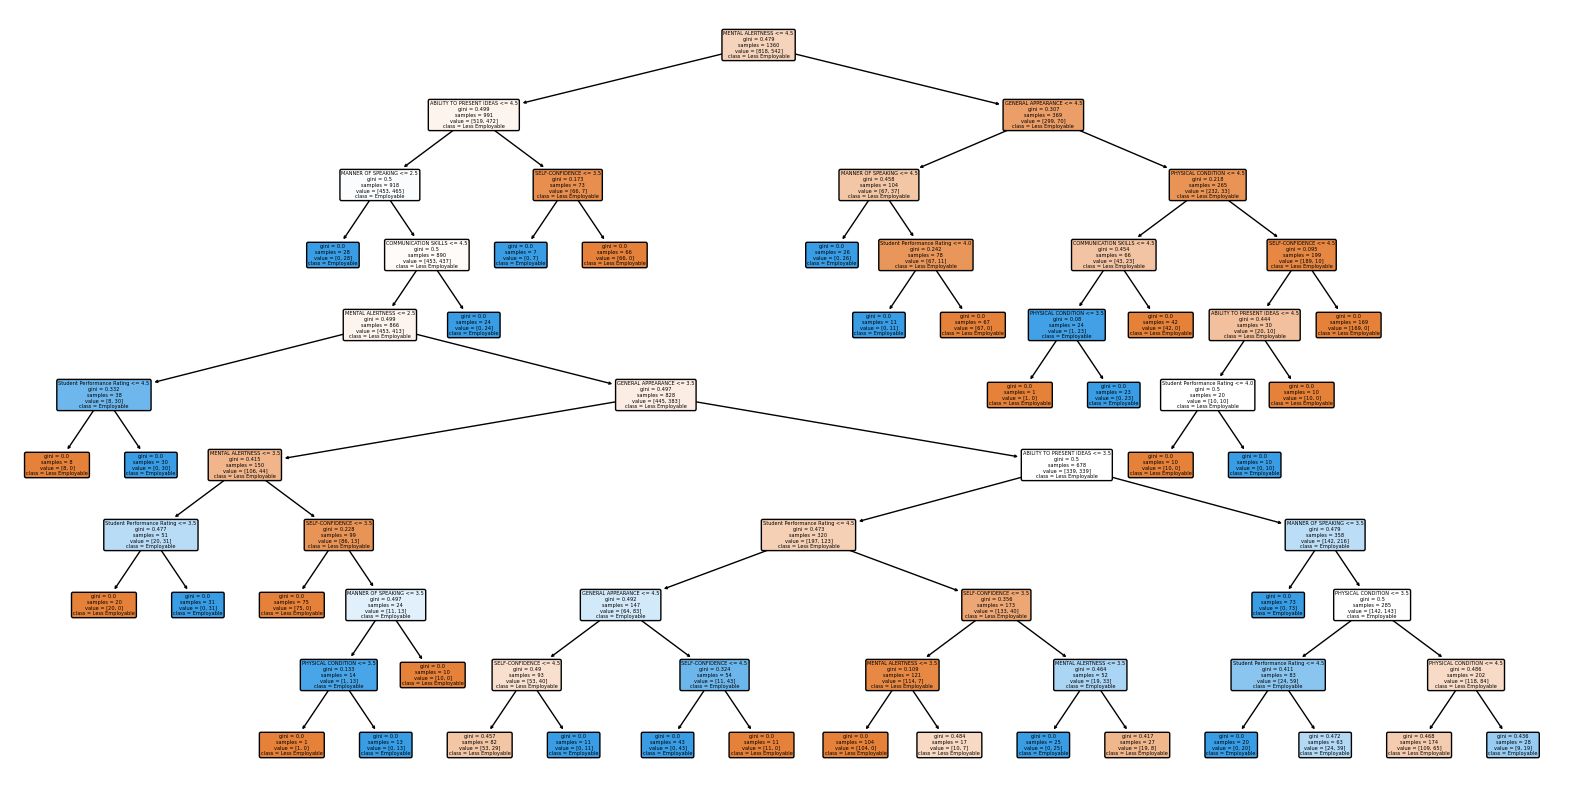

In [70]:
# Create and train the decision tree classifier
dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_classifier.fit(X_train_cleaned_identicals, y_train_cleaned_identicals)

# Make predictions
y_pred = dt_classifier.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Perform cross-validation
cv_scores = cross_val_score(dt_classifier, X_train_cleaned_identicals, y_train_cleaned_identicals, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualize the decision tree (limited to depth 3 for clarity)
plt.figure(figsize=(20,10))
plot_tree(dt_classifier, max_depth=10, feature_names=X.columns, class_names=['Less Employable', 'Employable'], filled=True, rounded=True)
plt.savefig('decision_tree.png')
print("\nDecision tree visualization saved as 'decision_tree.png'")

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_cleaned_identicals, y_train_cleaned_identicals)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train the model with best parameters
best_dt = grid_search.best_estimator_
best_dt.fit(X_train_cleaned_identicals, y_train_cleaned_identicals)
best_pred = best_dt.predict(X_test)

print("\nBest Model Accuracy:", accuracy_score(y_test, best_pred))
print("\nBest Model Classification Report:")
print(classification_report(y_test, best_pred))

In [28]:
def filter_dictionary(names, values, threshold):
    filtered_names = []
    filtered_values = []
    
    for name, value in zip(names, values):
        if value >= threshold:
            filtered_names.append(name)
            filtered_values.append(value)
    
    return {'names': filtered_names, 'values': filtered_values}


In [29]:
# Use only the selected features
threshold = 0.1
selected_features = filter_dictionary(feature_importance['feature'], feature_importance['importance'], threshold)

# Use only the selected features
X_train_selected = X_train[selected_features['names']]
X_test_selected = X_test[selected_features['names']]


In [ ]:
X_train_selected

In [31]:
# Train a new model using the selected features
clf_selected = DecisionTreeClassifier(random_state=42)
clf_selected.fit(X_train_selected, y_train)

DecisionTreeClassifier(random_state=42)

In [32]:

# Make predictions on the test set using the model trained with selected features
y_pred_selected_features = clf_selected.predict(X_test_selected)

# Calculate the accuracy of the model with selected features
accuracy_selected_features = accuracy_score(y_test, y_pred_selected_features)
print(f'Accuracy with selected features: {accuracy_selected_features}')
print(f'Accuracy with all features: {accuracy}')

Accuracy with selected features: 0.8609715242881072
Accuracy with all features: 0.9112227805695142


In [33]:
df.columns

Index(['Name of Student', 'GENERAL APPEARANCE', 'MANNER OF SPEAKING',
       'PHYSICAL CONDITION', 'MENTAL ALERTNESS', 'SELF-CONFIDENCE',
       'ABILITY TO PRESENT IDEAS', 'COMMUNICATION SKILLS',
       'Student Performance Rating', 'CLASS'],
      dtype='object')

check: defaultdict(<function <lambda> at 0x000001FDD612DA60>, {(5, 4): {'blue': 115, 'orange': 66}, (4, 4): {'blue': 313, 'orange': 454}, (3, 4): {'blue': 314, 'orange': 165}, (2, 3): {'blue': 0, 'orange': 17}, (4, 5): {'blue': 245, 'orange': 175}, (5, 5): {'blue': 496, 'orange': 115}, (4, 3): {'blue': 134, 'orange': 32}, (2, 4): {'blue': 16, 'orange': 33}, (3, 3): {'blue': 80, 'orange': 98}, (3, 5): {'blue': 16, 'orange': 82}, (3, 2): {'blue': 0, 'orange': 16}})


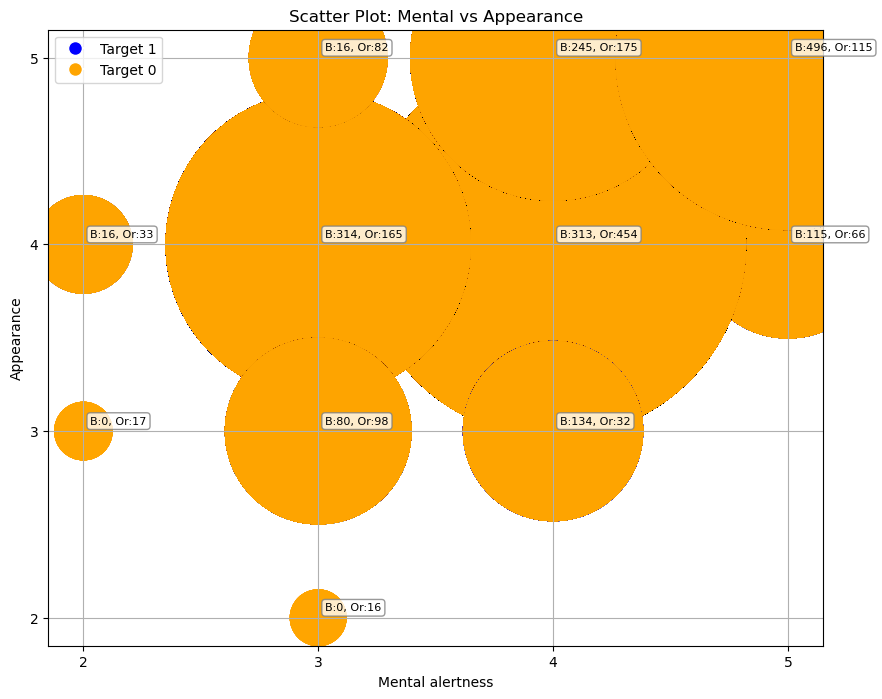

Counts at each coordinate:
(5, 4): Blue = 115, Orange = 66
(4, 4): Blue = 313, Orange = 454
(3, 4): Blue = 314, Orange = 165
(2, 3): Blue = 0, Orange = 17
(4, 5): Blue = 245, Orange = 175
(5, 5): Blue = 496, Orange = 115
(4, 3): Blue = 134, Orange = 32
(2, 4): Blue = 16, Orange = 33
(3, 3): Blue = 80, Orange = 98
(3, 5): Blue = 16, Orange = 82
(3, 2): Blue = 0, Orange = 16


In [34]:
# Create a dictionary to store the count of points at each coordinate
point_counts = defaultdict(lambda: {'blue': 0, 'orange': 0})

# Convert target to binary using a lambda function
target_to_binary = lambda x: 1 if x == 'Employable' else 0
df['target_binary'] = df['CLASS'].apply(target_to_binary)

# Count the number of blue and orange points at each coordinate
for _, row in df.iterrows():
    x, y, target = row['MENTAL ALERTNESS'], row['GENERAL APPEARANCE'], row['target_binary']
    color = 'blue' if target == 1 else 'orange'
    point_counts[(x, y)][color] += 1
print(f'check: {point_counts}')
# Prepare data for plotting
x = []
y = []
colors = []
sizes = []

for (x_coord, y_coord), counts in point_counts.items():
    total_count = counts['blue'] + counts['orange']
    x.extend([x_coord] * total_count)
    y.extend([y_coord] * total_count)
    colors.extend(['blue'] * counts['blue'] + ['orange'] * counts['orange'])
    sizes.extend([100 * total_count] * total_count)  # Adjust size based on total count

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x, y, c=colors, s=sizes, alpha=0.6)

plt.xlabel('Mental alertness')
plt.ylabel('Appearance')
plt.title('Scatter Plot: Mental vs Appearance')

# Set integer ticks for x and y axes
plt.xticks(range(2, 6))
plt.yticks(range(2, 6))

# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Target 1')
orange_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Target 0')
plt.legend(handles=[blue_patch, orange_patch])

# Annotate points with counts
for (x_coord, y_coord), counts in point_counts.items():
    total_count = counts['blue'] + counts['orange']
    if total_count > 1:
        plt.annotate(f"B:{counts['blue']}, Or:{counts['orange']}", 
                     (x_coord, y_coord), 
                     xytext=(5, 5), 
                     textcoords='offset points', 
                     fontsize=8, 
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.grid(True)
plt.show()

# Print the counts
print("Counts at each coordinate:")
for (x_coord, y_coord), counts in point_counts.items():
    print(f"({x_coord}, {y_coord}): Blue = {counts['blue']}, Orange = {counts['orange']}")
